## Programming Assignment #1

**[DFT-IDFT of a speech signal using overlap add method]**
- Read the input .wav file.
- For each frame of 80 samples, take FFT and reconstruct the signal via IFFT. Use the overlap add method.
- Plot of the magnitude spectrum for the 100 th frame.
- Plot of the difference between input and output (time domain) signals.

In [34]:
import torch
from torch.fft import fft, ifft
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def overlap_add (signal, frame_size):
    frame_num = (len(signal) + frame_size -1) // frame_size
    output_signal = torch.zeros(len(signal) + frame_size)

    for i in range(frame_num):
        start = i * frame_size
        end = start + frame_size
        if end < (i+1) * frame_size:
            frame = signal[start:]
        else:
            frame = signal[start:end]
    
        # Zero-padding if the frame is smaller than frame_size
        if len(frame) < frame_size:
            frame = torch.nn.functional.pad(frame, (0, frame_size - len(frame)))

        spectrum = torch.fft.fft(frame)
        reconstructed_frame = torch.fft.ifft(spectrum).real

        output_signal[start:end] += reconstructed_frame

    return output_signal[:len(signal)]  

In [36]:
def plot_magnitude_spectrum(frame):
    spectrum = torch.fft.fft(frame)
    magnitude_spectrum = torch.abs(spectrum)
    plt.figure(figsize=(10,4))
    plt.plot(magnitude_spectrum)
    plt.title("Magnitude spectrum for the 100th frame")
    plt.xlim(0,40)
    plt.xlabel("Frequency bin")
    plt.ylabel("Magnitude")
    # plt.colorbar(format='%+2.0f dB')
    plt.show()

In [37]:
def plot_difference(input_signal, output_signal):
    difference = input_signal - output_signal
    plt.figure(figsize=(10,4))
    plt.plot(difference)
    plt.title("Difference between input and output signals")
    plt.xlabel("Sample")
    plt.ylabel("Difference")
    plt.show()

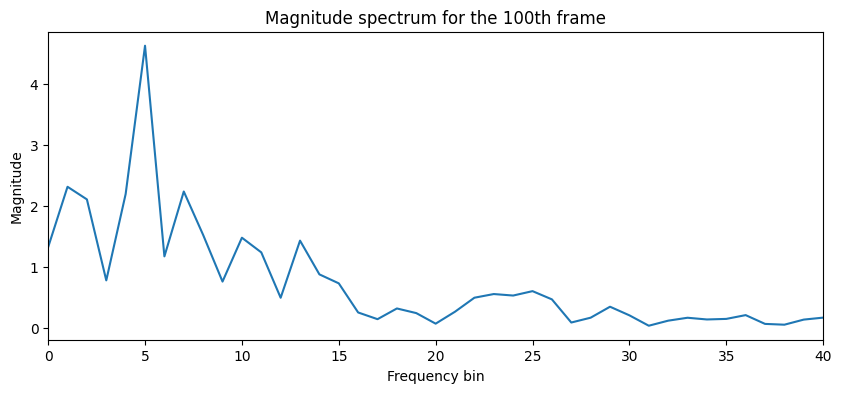

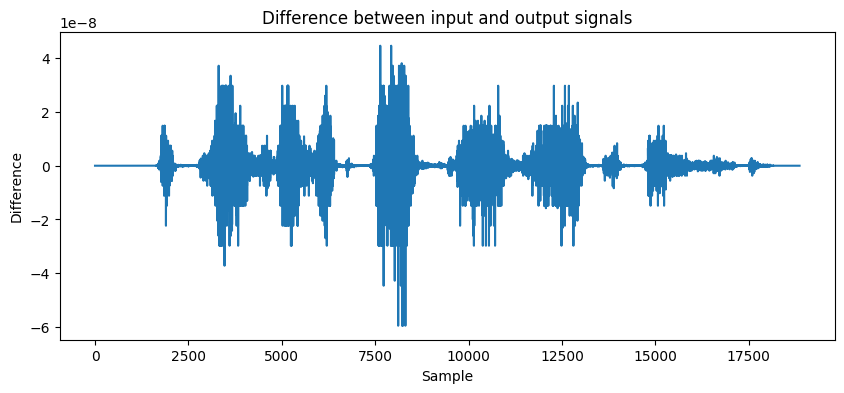

In [38]:
frame_size = 80
waveform, sr = torchaudio.load('input.wav')
waveform = waveform[0]

# overlap-add method
output_signal = overlap_add(waveform, frame_size)

# Plot of magnitude spectrum for the 100th frame
start = 99 * frame_size
end = start + frame_size
ff = output_signal[start:end]
plot_magnitude_spectrum(ff)

# Plot of the difference between input and output (time domain) signals
plot_difference(waveform.squeeze(0), output_signal)

# Save output file
torchaudio.save("output1.wav", output_signal, sr)

## Programming Assignment #2

**[DFT LPF IDFT of a speech signal using overlap add and overlap save method]**
- Read the input .wav file.
- The LPF is simply moving average filter, i.e., ℎ[𝑛]=1,0≤𝑛≤10 (𝑃=11)

**1) For overlap add method,**
- Frame shift is 80 samples. (𝐿=80)
- For every 80 samples, take 128 point FFT. (𝑁=128)
- Multiply it with the FFT of the filter.
- Compute 128 point IFFT and reconstruct the time domain signal.
- Plot of the magnitude spectrum for the 100th frame with that of the input signal before filtering for each method.
- Compare the outputs of the overlap add and overlap save methods.

In [39]:
def overlap_add2(signal, LPF, frame_shift, fft_point, overlap_length):
    output_length1 = waveform.size(0) + overlap
    output_signal1 = torch.zeros(output_length1)
    h_fft = torch.fft.fft(h, N)

    for i in range(0, waveform.size(0), L):
        frame = waveform[i:i+L]

        frame_fft = torch.fft.fft(frame, N)
        filtered_frame_fft = frame_fft * h_fft
        
        if i == 99*80:
            before_filtering1 = frame_fft
            after_filtering1 = filtered_frame_fft
        filtered_frame = torch.fft.ifft(filtered_frame_fft)

        frame_length = min(N, output_signal1.size(0) - i)
        output_signal1[i:i + frame_length] += filtered_frame[:frame_length].real
    
    return output_signal1[:waveform.size(0)], before_filtering1, after_filtering1


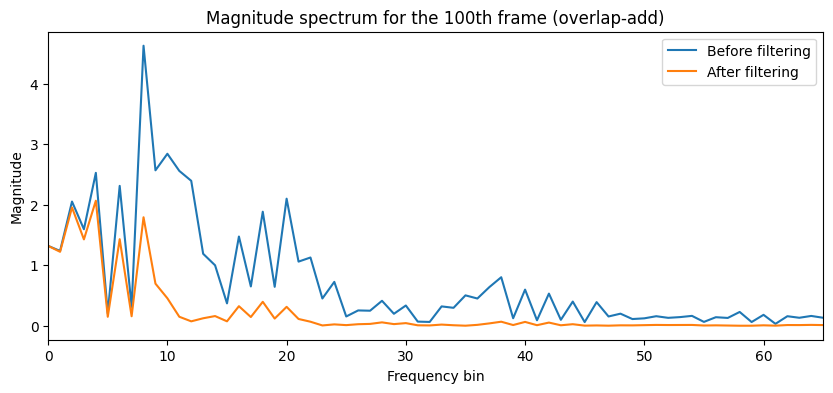

In [40]:
waveform, sr = torchaudio.load('input.wav')
waveform = waveform[0]

P = 11
h = torch.ones(P) / P
L = 80  
N = 128
overlap = N - L 

output2_1, before_filtering1, after_filtering1 = overlap_add2(waveform, h, L, N, overlap)
torchaudio.save("output2_1.wav", output2_1.unsqueeze(0), sr)

Y1 = abs(before_filtering1)
Y2 = abs(after_filtering1)
plt.figure(figsize=(10,4))
plt.plot(Y1, label = 'Before filtering')
plt.plot(Y2, label = 'After filtering')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame (overlap-add)")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Y0 = abs(torch.fft.fft(waveform[99*80:100*80]))
# plt.plot(Y0, label = 'Original')

**[DFT LPF IDFT of a speech signal using overlap add and overlap save method]**
- Read the input .wav file.
- The LPF is simply moving average filter, i.e., ℎ[𝑛]=1,0≤𝑛≤10 (𝑃=11)

**2) For overlap save method,**
- Frame shift is 80 samples. (𝐿−𝑃+1=80→𝐿=90)
- For every 80 samples, take 128 point FFT for 90 samples of input. (𝑁=128)
- Multiply it with the FFT of the filter.
- Compute 128 point IFFT and reconstruct the time domain signal.
- Plot of the magnitude spectrum for the 100th frame with that of the input signal before filtering for each method.
- Compare the outputs of the overlap add and overlap save methods.

In [41]:
def overlap_save(signal, LPF, frame_size, fft_point, frame_shift):
    h_fft = torch.fft.fft(h, n=N)
    num_frames = (waveform.size(0) - L + frame_shift) // frame_shift
    output_signal2 = torch.zeros(waveform.size(0))

    for i in range(num_frames):
        start_idx = i * frame_shift
        end_idx = start_idx + L
        
        if end_idx > waveform.size(0):
            break
        
        frame = waveform[start_idx:end_idx]
        frame_padded = torch.cat([frame, torch.zeros(N - L)])
        
        frame_fft = torch.fft.fft(frame_padded, n=N)
        filtered_frame_fft = frame_fft * h_fft
        filtered_padded = torch.fft.ifft(filtered_frame_fft, n=N).real
        
        output_signal2[start_idx:start_idx + frame_shift] += filtered_padded[P-1:L]

        if i == 99:
            before_filtering2 = frame_fft
            after_filtering2 = filtered_frame_fft

    return output_signal2[:waveform.size(0)], before_filtering2, after_filtering2


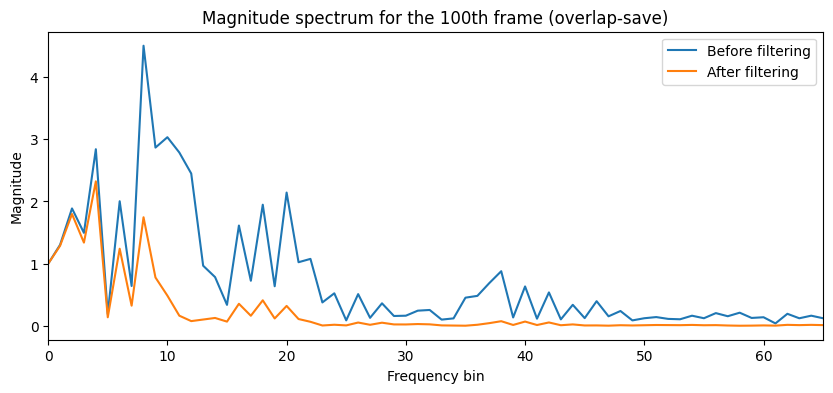

In [42]:
waveform, sr = torchaudio.load('input.wav')
waveform = waveform[0] 

P = 11
h = torch.ones(P) / P
L = 90
N = 128
shift = 80

output2_2, before_filtering2, after_filtering2 = overlap_save(waveform, h, L, N, shift)
torchaudio.save('output2_2.wav', output2_2.unsqueeze(0), sr)

Y3 = abs(before_filtering2)
Y4 = abs(after_filtering2)
plt.figure(figsize=(10,4))
plt.plot(Y3, label = 'Before filtering')
plt.plot(Y4, label = 'After filtering')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame (overlap-save)")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

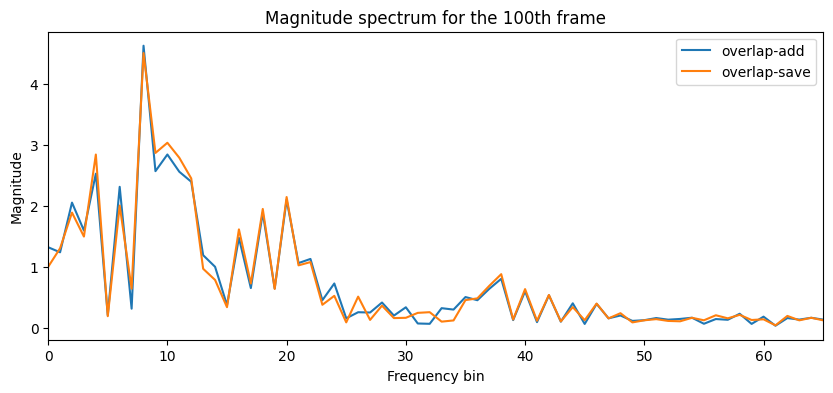

In [43]:
plt.figure(figsize=(10,4))
plt.plot(Y1, label = 'overlap-add')
plt.plot(Y3, label = 'overlap-save')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

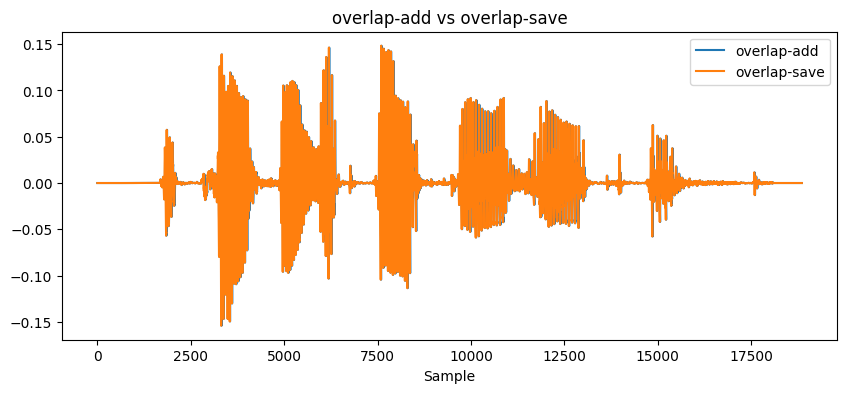

In [44]:
plt.figure(figsize=(10,4))
plt.plot(output2_1, label="overlap-add")
plt.plot(output2_2, label="overlap-save")
plt.title("overlap-add vs overlap-save")
plt.xlabel("Sample")
plt.legend()
plt.show()


## Programming Assignment #3

**[DFT-LPF-IDFT of a speech signal using overlap add method with windowing]**
- Read the input .wav file.
- The LPF is simply moving average filter, i.e., ℎ[𝑛]=1,0≤𝑛≤10 (𝑃=11)
- Use overlap add method.
- Frame shift is 80 samples. (𝐿=80)
- 128 samples are prepared for the analysis; The first 24 samples are the last 24 samples of the previous frame. The next 80 samples are from the current frame. The last 24 samples are zeros.
- The window is: the first half of the 48 point Hann window from 0 23; 1.0 for the next 56 samples; the second half of the 48 point Hann window for the last 24 samples.
- 128 point FFT is taken for this 128 samples.
- Multiply it with the FFT of the filter.
- Compute 128 point IFFT and reconstruct the time domain signal.

In [53]:
import scipy.signal

def overlap_add3(signal, LPF, window, frame_shift, fft_point):
    h_fft = torch.fft.fft(h, n=N)
    num_frames = (waveform.size(0) + L - 1) // L
    output_signal_length = L * num_frames + (N - L)
    output_signal3 = torch.zeros(output_signal_length)
    padded_signal = torch.cat([torch.zeros(24), waveform, torch.zeros(N - (waveform.size(0) % L) - 24)])

    for i in range(num_frames):
        start_idx = i * 80
        end_idx = start_idx + N
        frame = padded_signal[start_idx:end_idx]

        if frame.size(0) < N:
            frame = torch.cat([frame, torch.zeros(N - frame.size(0))])

        windowed_frame = frame * window
        frame_fft = torch.fft.fft(windowed_frame, n=N)
        filtered_fft = frame_fft * h_fft
        filtered_frame = torch.fft.ifft(filtered_fft).real
        
        if i == 99:
            before_filtering3 = torch.abs(frame_fft)

        output_signal3[start_idx:start_idx + N] += filtered_frame
    return output_signal3[24:24+waveform.size(0)], before_filtering3



In [54]:
waveform, sr = torchaudio.load('input.wav')
waveform = waveform[0]

P = 11
h = torch.ones(P) / P
L = 80
N= 128

# Custom window
hann_window = scipy.signal.windows.hann(48)
window = torch.cat([
    torch.tensor(hann_window[:24]),
    torch.ones(56),
    torch.tensor(hann_window[24:]),
    torch.zeros(128 - 104)  
])

output3, before_filtering3 = overlap_add3(waveform, h, window, L, N)
torchaudio.save('output3.wav', output3.unsqueeze(0), sr)

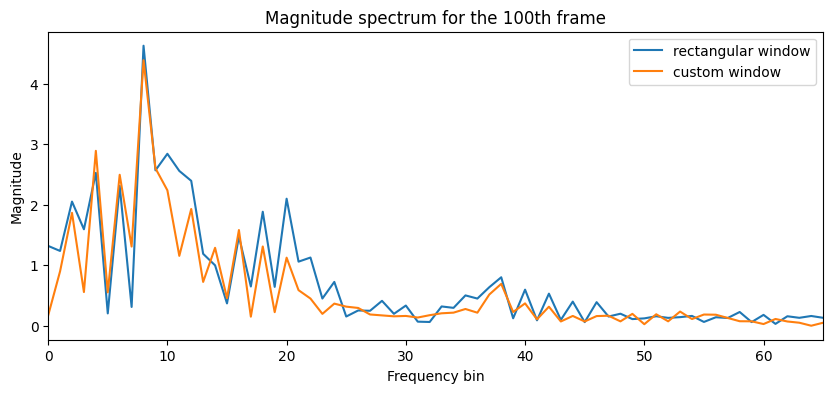

In [55]:
Y5 = abs(before_filtering3)
plt.figure(figsize=(10,4))
plt.plot(Y1, label = 'rectangular window')
plt.plot(Y5, label = 'custom window')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

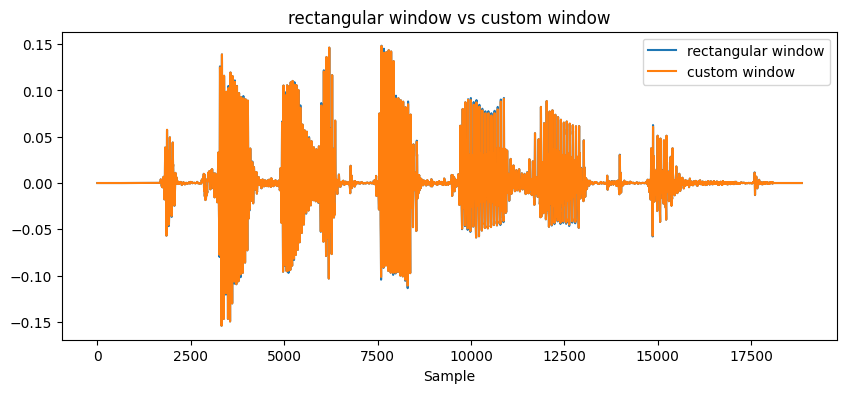

In [59]:
plt.figure(figsize=(10,4))
plt.plot(output2_1, label="rectangular window")
plt.plot(output3, label="custom window")
plt.title("rectangular window vs custom window")
plt.xlabel("Sample")
plt.legend()
plt.show()